## Trans conceptual sampling across borehole tomography models  #

Demonstrates Trans-C algorithm **Ensemble_resampler** applied to a borehole tomography problem. 

Four states are present which consists of 2D pixel grid models of differing sizes $nx \times ny$.

Sequential and up to **three levels** of parallelized execution modes are demonstrated during the pre-compute ensembles stage using routine `run_mcmc_per_state()`. 
Parallelization is demonstrated  over *states*, over *walkers* and within the *forward solver*. 
Here the forward solver is Fast Marching travel time calculation between sources and receivers. In this case parallelization is performed by the forward solver and is over sources.

In [1]:
%matplotlib inline
%load_ext watermark
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import scipy.stats as stats
from functools import partial
from sklearn.mixture import GaussianMixture

# pyTransC imports
from pytransc.samplers import run_mcmc_per_state, run_ensemble_resampler
from pytransc.utils.types import FloatArray
from pytransc.utils.auto_pseudo import build_auto_pseudo_prior
from pytransc.analysis.visits import (
    get_visits_to_states
)

In [2]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


--------

#### Utility routines for building seismic velocity models

### Cross-platform multiprocessing compatibility

**Note on macOS/Windows compatibility:** The functions below are defined in a separate module to ensure compatibility with multiprocessing on macOS and Windows.

- **Why?** macOS and Windows use `spawn` for multiprocessing (not `fork` like Linux)
- **What does this mean?** Functions must be picklable (defined at module level, not inline in notebooks)
- **Solution:** We use `%%writefile` to create a module file while keeping the code visible in the notebook

This ensures the notebook works on Linux, macOS, and Windows without modification.

In [3]:
%%writefile tomography_functions.py
"""
Tomography example functions for Trans-C sampling.

These functions are defined in a separate module to ensure compatibility
with multiprocessing on macOS and Windows, which use 'spawn' instead of 'fork'.
"""

import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from functools import partial
import pyfm2d


def get_gauss_model(extent, nx, ny, factor=1.):
    """Build two gaussian anomaly velocity model."""
    vc1 = 1700 * factor  # velocity of circle 1 in m/s
    vc2 = 2300 * factor  # velocity of circle 2 in m/s
    vb = 2000 * factor  # background velocity
    dx = (extent[1] - extent[0]) / nx  # cell width
    dy = (extent[3] - extent[2]) / ny  # cell height
    xc = np.linspace(extent[0], extent[1], nx)  # cell centre
    yc = np.linspace(extent[2], extent[3], ny)  # cell centre
    X, Y = np.meshgrid(xc, yc, indexing='ij')  # cell centre mesh

    # Multivariate Normal
    dex = extent[1] - extent[0]
    dey = extent[3] - extent[2]
    c1x = extent[0] + (7.0 - extent[0]) * dex / 20.
    c2x = extent[0] + (12.0 - extent[0]) * dex / 20.
    c1y = extent[0] + (22.0 - extent[0]) * dey / 30.
    c2y = extent[0] + (10.0 - extent[0]) * dey / 30.
    s1 = 6.0 * dex / 20.
    s2 = 10.0 * dex / 20.
    c1, sig1 = np.array([c1x, c1y]) * factor, s1 * (factor ** 2)
    c2, sig2 = np.array([c2x, c2y]) * factor, s2 * (factor ** 2)
    rv1 = multivariate_normal(c1, [[sig1, 0], [0, sig1]])
    rv2 = multivariate_normal(c2, [[sig2, 0], [0, sig2]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    gauss1, gauss2 = rv1.pdf(pos), rv2.pdf(pos)
    return vb * np.ones([nx, ny]) + (vc1 - vb) * gauss1 / np.max(gauss1) + (vc2 - vb) * gauss2 / np.max(gauss2)


def generate_covariance_matrix_inv(model_shape: tuple, corr_lengths: tuple, sigma: float):
    """Gaussian inverse covariance matrix implementation."""
    if len(model_shape) != len(corr_lengths):
        raise ValueError(
            "`model_shape` and `corr_lengths` should have the same lengths, "
            f"but got {len(model_shape)} and {len(corr_lengths)}"
        )
    grids = np.meshgrid(*[np.arange(dim) for dim in model_shape], indexing="ij")
    d_squared = sum(
        [
            (grid.ravel()[None, :] - grid.ravel()[:, None]) ** 2 / corr_length ** 2
            for grid, corr_length in zip(grids, corr_lengths)
        ]
    )
    Cp = np.exp(-np.sqrt(d_squared))
    Sc = np.zeros((np.prod(model_shape), np.prod(model_shape)))
    np.fill_diagonal(Sc, sigma)
    covariance_matrix = Sc @ Cp @ Sc
    covariance_matrix_inv = np.linalg.inv(covariance_matrix)
    return covariance_matrix_inv, covariance_matrix

def _log_prior(x, state, stateparams):
    """Calculate log prior for given state."""
    rv = stateparams['rv'][state]
    return rv.logpdf(x)


def _log_likelihood(x, state, tobs, Cdinv, recs, srcs, extent, options, stateparams):
    """Calculate log likelihood for tomography model."""
    nx, ny = stateparams['nx'][state], stateparams['ny'][state]
    velocity = 1. / x.reshape((nx, ny))
    result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
    res = tobs - result.ttimes
    LL = -0.5 * res.T @ Cdinv @ res
    return LL


def _log_posterior_base(x, state, log_prior_func, log_likelihood_func):
    """Calculate log posterior."""
    lp = log_prior_func(x, state)
    ll = log_likelihood_func(x, state)
    return ll + lp


def _log_likelihood_with_forward_pool(x, state, tobs, Cdinv, recs, srcs, extent, options, stateparams):
    """Calculate log likelihood using forward pool for parallel computation."""
    from pytransc.utils.forward_context import get_forward_pool

    forward_pool = get_forward_pool()
    nx, ny = stateparams['nx'][state], stateparams['ny'][state]
    velocity = 1. / x.reshape((nx, ny))
    result = pyfm2d.calc_wavefronts(velocity, recs, srcs, pool=forward_pool, extent=extent, options=options)
    res = tobs - result.ttimes
    LL = -0.5 * res.T @ Cdinv @ res
    return LL


def _log_posterior_with_forward_pool_base(x, state, log_prior_func, log_likelihood_with_forward_pool_func):
    """Calculate log posterior with forward pool support."""
    lp = log_prior_func(x, state)
    ll = log_likelihood_with_forward_pool_func(x, state)
    return ll + lp

Overwriting tomography_functions.py


In [4]:
# Import the functions from the module we just created
from tomography_functions import (
    get_gauss_model,
    generate_covariance_matrix_inv,
    _log_prior,
    _log_likelihood,
    _log_posterior_base,
    _log_likelihood_with_forward_pool,
    _log_posterior_with_forward_pool_base
)

### Build high resolution reference velocity model and calculate travel times

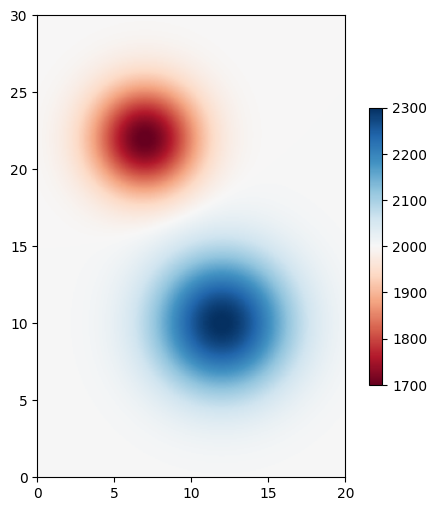

In [5]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
gtrue = pyfm2d.BasisModel(m, extent=extent)
velocity = gtrue.get_velocity()
pyfm2d.display_model(velocity, extent=extent, figsize=(6, 6), clim=(1700, 2300))

Use this arrangement of sources and receivers to get 1024 ray paths and travel times.

In [6]:
# build sources and receivers for model
# create 64 sources on left and 16 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    16, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    64, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

Use this arrangement of sources and receivers to get 128 ray paths and travel times.

In [7]:
# sources and receivers for quicker forward modelling
# create 10 sources on left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    8, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    16, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

In [8]:
# run wave front tracker to get true times in reference model
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=False,
    paths=True,
    cartesian=True,
    quiet=True,
)

start = time.time()
result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
end = time.time()
print(" Wall time:",end - start)

print(" Number of paths calculated = ", len(result.paths))
print(" Number of travel times calculated = ", len(result.ttimes))
#print(" Shape of frechet matrix = ", result.frechet.shape)


 Wall time: 0.5101668834686279
 Number of paths calculated =  128
 Number of travel times calculated =  128


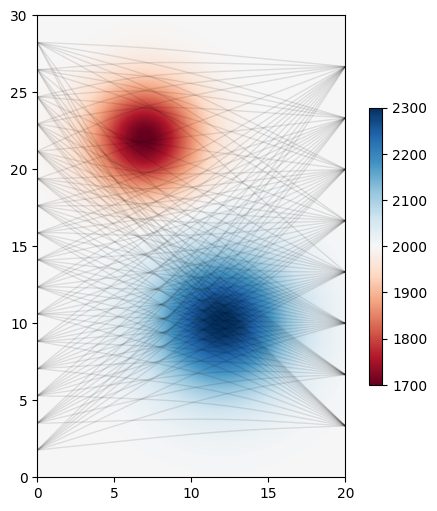

In [9]:
# display continuous model and raypaths
pyfm2d.display_model(
    velocity,
    extent=extent,
    figsize=(6, 6),
    clim=(1700, 2300),
    paths=result.paths,
    recs=recs,
    srcs=srcs,
    alpha=0.1,
)

Add noise to travel times to form tomography dataset.

In [10]:
# data set up
sigma = 0.0001 # standard deviation of data noise
np.random.seed(61254557)
ttrue = result.ttimes
tobs = ttrue + sigma*np.random.randn(len(ttrue))
print('Noise is ',sigma/np.std(ttrue)*100,'% of travel times standard deviation')
Cdinv = np.eye(len(tobs))/(sigma**2)  # Data covariance matrix
Cd = np.eye(len(tobs))*sigma**2 # Inverse Data covariance matrix

Noise is  6.797304 % of travel times standard deviation


### Define model states

In [11]:
# propertes of each model state
stateparams = {}
nstates = 4
# model sizes are limited by the need to have twice the number of MCMC walkers than the model dimension = nx*ny
#
stateparams['nx'] = [32,16,8,4] # Large scale model with high model dimensions (requires at least 2*32x48 McMC walkers)
stateparams['ny'] = [48,24,12,6]
stateparams['corrx'] = [8,4,2,1]
stateparams['corry'] = [8,4,2,1]
# model sizes are limited by the need to have twice the number of MCMC walkers than the model dimension = nx*ny
stateparams['nx'] = [7,6,5,4] # Moderate scale model with model dimensions (requires at least 2*9x11 McMC walkers)
stateparams['ny'] = [9,8,7,6]
corrkm = 2  # Spatial Gaussian correlation y-length for prior covariance matrix in spatial units
stateparams['corrx'] = [1,1,1,1]
stateparams['corry'] = [1,1,1,1]
sigma_slowness = 2.5E-6 # standard deviation of slowness in model covaraince function
Cm_inv,Cm,sref,rvs,gs,corrxl,corryl = [None] * nstates, [None] * nstates, [None] * nstates, [None] * nstates, [None] * nstates, [None] * nstates, [None] * nstates
for state in range(nstates): # loop over states
    nx,ny = stateparams['nx'][state], stateparams['ny'][state]
    corrx = corrkm*nx/(extent[1]-extent[0])         # Spatial Gaussian correlation x-length for prior covariance matrix (units of grid nodes)
    corry = corrkm*ny/(extent[3]-extent[2])         # Spatial Gaussian correlation y-length for prior covariance matrix (units of grid nodes)
    Cm_inv[state],Cm[state] = generate_covariance_matrix_inv((nx, ny), (corrx,corry), sigma_slowness) # Gaussian model covariance matrices in slowness
    gs[state] = pyfm2d.BasisModel(get_gauss_model(extent, nx, ny), extent=extent) # parameterization class
    sref[state] = np.ones([nx,ny]).flatten()/2000. # reference slowness for model covariance
    Cm[state] = sigma_slowness*np.eye(nx*ny)
    rvs[state] = stats.multivariate_normal(mean=sref[state], cov=Cm[state])  # instance of multi-dimensional Gaussian  
    corrxl[state] = corrx
    corryl[state] = corry
stateparams['Cm'] = Cm
stateparams['Cm_inv'] = Cm_inv
stateparams['sref'] = sref
stateparams['g'] = gs
stateparams['rv'] = rvs
stateparams['corrx'][state] = corrxl
stateparams['corry'][state] = corryl

Plot the true model projected onto the parameterization in each state.

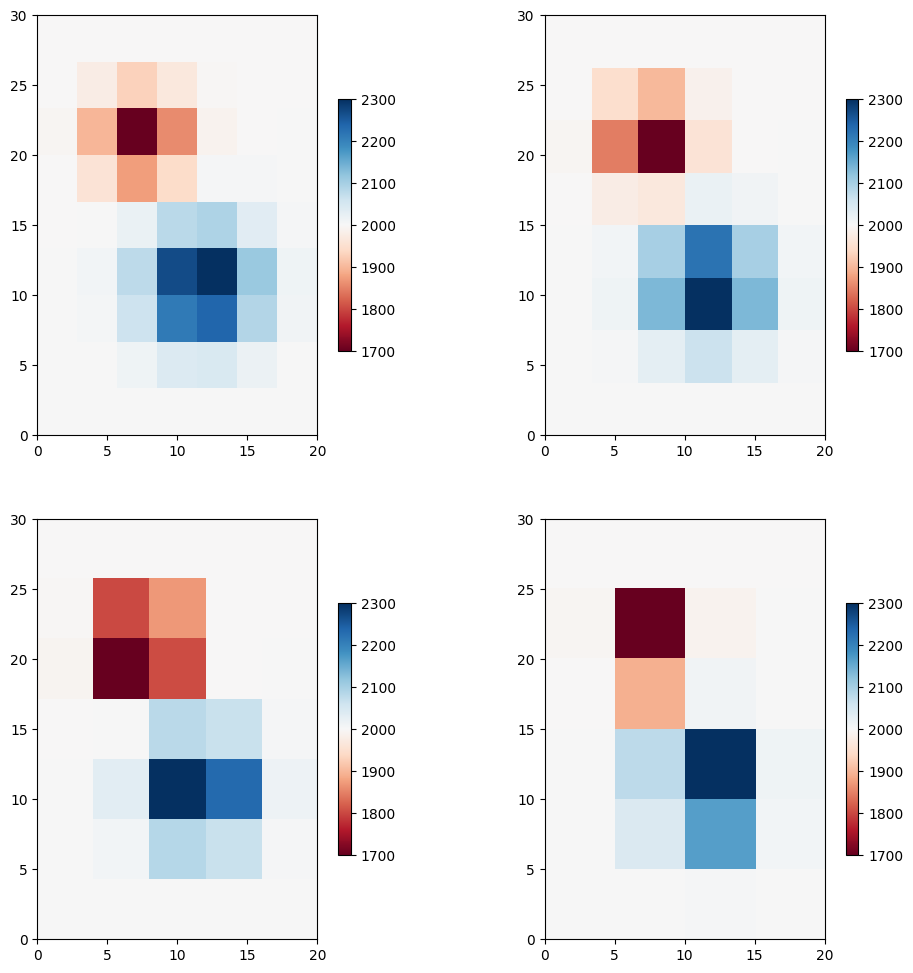

In [12]:
fig, axes_2d = plt.subplots(2,2,figsize=(12,12))
axes = axes_2d.flatten()
for state in range(nstates):
    g = stateparams['g'][state]
    pyfm2d.display_model(g.get_velocity(), extent=extent, ax = axes[state], clim=(1700, 2300),diced=False)

Four pixel based model states are used with varying resolutions.

### Log Likelihood and prior for each state

In [13]:
# Create partial functions for log prior
log_prior = partial(_log_prior, stateparams=stateparams)

In [14]:
# Create partial functions for log likelihood
log_likelihood = partial(_log_likelihood, tobs=tobs, Cdinv=Cdinv, recs=recs, srcs=srcs, extent=extent, options=options, stateparams=stateparams)

In [15]:
# Create log posterior using imported base function
log_posterior = partial(_log_posterior_base, log_prior_func=log_prior, log_likelihood_func=log_likelihood)

In [16]:
# Create partial functions for log likelihood with forward pool
log_likelihood_with_forward_pool = partial(_log_likelihood_with_forward_pool, tobs=tobs, Cdinv=Cdinv, recs=recs, srcs=srcs, extent=extent, options=options, stateparams=stateparams)

In [17]:
# Create log posterior with forward pool using imported base function
log_posterior_with_forward_pool = partial(_log_posterior_with_forward_pool_base, log_prior_func=log_prior, log_likelihood_with_forward_pool_func=log_likelihood_with_forward_pool)

In [18]:
# generate random starting models centred near MAP
ndims = [stateparams['nx'][i]*stateparams['ny'][i] for i in range(nstates)]
nwalkers = 128  # Number of MCMC walkers
nsteps = 50  # Needs at least 5000 steps for prior sampling but we can't wait that long so the length of each chain is set to a unrealistic small number.
pos = []
for state in range(nstates): # loop over states
    nx,ny = stateparams['nx'][state], stateparams['ny'][state]
    rv = stats.multivariate_normal(mean=np.zeros(nx*ny), cov=np.eye(nx*ny))
    slow = 1./get_gauss_model(extent, nx, ny).flatten() + sigma_slowness*rv.rvs(size=nwalkers)
    pos.append(slow)
    lp = log_prior(slow[0],state)
    ll = log_likelihood(slow[0],state)
    lpos = log_posterior(slow[0],state)
    print(' log-prior ',lp,' log-Likelihood ',ll,' lpost',lpos)

 log-prior  348.4267623600669  log-Likelihood  -80.45919936547526  lpost 267.9675629945916
 log-prior  265.4679992392613  log-Likelihood  -96.90262572489524  lpost 168.56537351436606
 log-prior  193.5688513336779  log-Likelihood  -174.68358931057116  lpost 18.885262023106748
 log-prior  132.73312337210024  log-Likelihood  -119.4145703267831  lpost 13.318553045317131


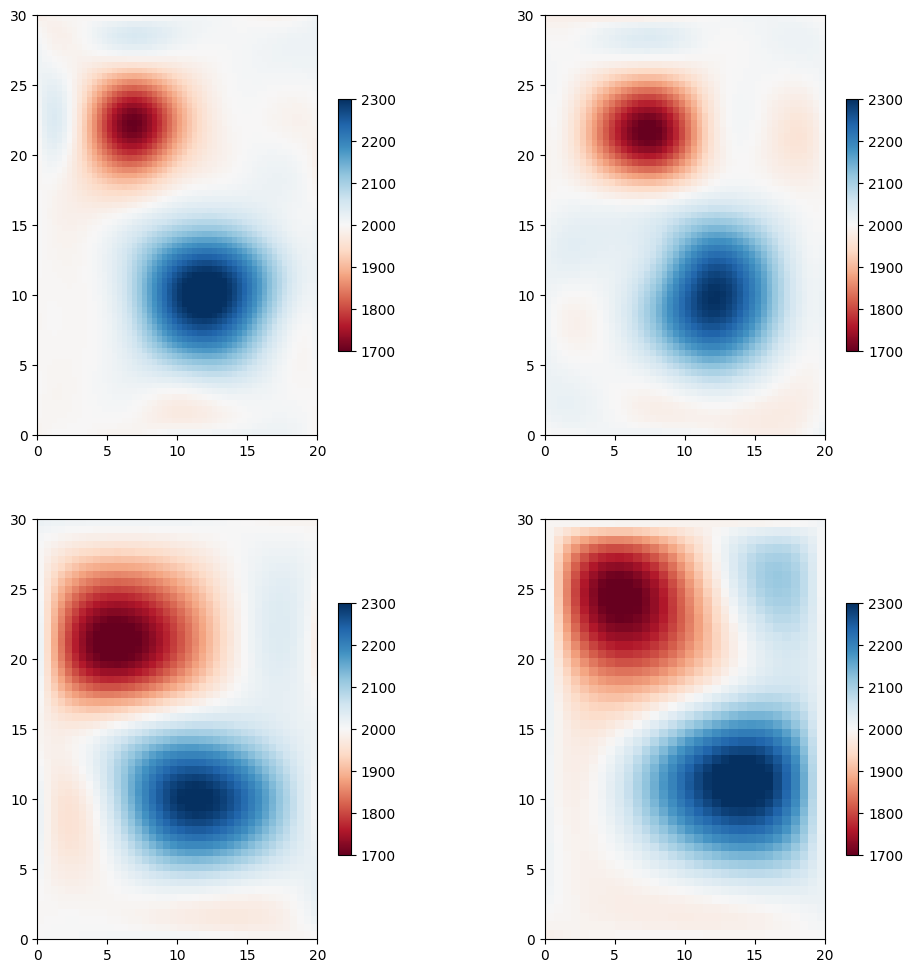

In [19]:
# plot the starting models
if(True):
    posll = []
    fig, axes_2d = plt.subplots(2,2,figsize=(12,12))
    axes = axes_2d.flatten()
    for state in range(nstates):
        nx,ny = stateparams['nx'][state], stateparams['ny'][state]
        pyfm2d.display_model(1./pos[state][0].reshape((nx,ny)), extent=extent, ax = axes[state], clim=(1700, 2300))
        posll.append(log_likelihood(pos[state][state],state))

### Sequential

In [20]:
# Sequential 

start_time = time.time()

ensembles_seq, log_probs_seq = run_mcmc_per_state(
    n_states=nstates,
    n_dims=ndims,
    n_walkers=nwalkers,
    n_steps=nsteps,
    pos=pos,
    log_posterior=log_prior,
    verbose=True,
    skip_initial_state_check=True,
)

sequential_time = time.time() - start_time

print(f"\nSequential execution completed in {sequential_time:.2f} seconds")
print(f"Sample shapes: {[ens.shape for ens in ensembles_seq]}")
print(f"Log prob shapes: {[lp.shape for lp in log_probs_seq]}")


Running within-state sampler separately on each state

Number of walkers               :  [128, 128, 128, 128]

Number of states being sampled:  4
Dimensions of each state:  [63, 48, 35, 24]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 695.39it/s]


Sequential execution completed in 0.60 seconds
Sample shapes: [(6400, 63), (6400, 48), (6400, 35), (6400, 24)]
Log prob shapes: [(6400,), (6400,), (6400,), (6400,)]


### State level parallelism

In [21]:
# State-Level Parallelism Only

start_time = time.time()

n_state_procs=2
with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool:
    ensembles_seq, log_probs_seq = run_mcmc_per_state(
        n_states=nstates,
        n_dims=ndims,
        n_walkers=nwalkers,
        n_steps=nsteps,
        pos=pos,
        log_posterior=log_posterior,
        verbose=True,
        skip_initial_state_check=True,
        state_pool=state_pool,
)

state_level_parallel_time = time.time() - start_time

print(f"\nState level parallel execution completed in {state_level_parallel_time:.2f} seconds")
print(f"Sample shapes: {[ens.shape for ens in ensembles_seq]}")
print(f"Log prob shapes: {[lp.shape for lp in log_probs_seq]}")


Running within-state sampler separately on each state

Number of walkers               :  [128, 128, 128, 128]

Number of states being sampled:  4
Dimensions of each state:  [63, 48, 35, 24]
Using state-level parallelism


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]



State level parallel execution completed in 194.32 seconds
Sample shapes: [(6400, 63), (6400, 48), (6400, 35), (6400, 24)]
Log prob shapes: [(6400,), (6400,), (6400,), (6400,)]


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


### Walker level parallelism

In [22]:
# Walker-Level Parallelism Only

start_time = time.time()
n_walker_procs=2
with ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:
    ensembles_seq, log_probs_seq = run_mcmc_per_state(
        n_states=nstates,
        n_dims=ndims,
        n_walkers=nwalkers,
        n_steps=nsteps,
        pos=pos,
        log_posterior=log_posterior,
        verbose=True,
        skip_initial_state_check=True,
        emcee_pool=walker_pool,  # Walker parallelism only
)

walker_level_parallel_time = time.time() - start_time

print(f"\nWalker level parallel execution completed in {walker_level_parallel_time:.2f} seconds")
print(f"Sample shapes: {[ens.shape for ens in ensembles_seq]}")
print(f"Log prob shapes: {[lp.shape for lp in log_probs_seq]}")


Running within-state sampler separately on each state

Number of walkers               :  [128, 128, 128, 128]

Number of states being sampled:  4
Dimensions of each state:  [63, 48, 35, 24]
Using walker-level parallelism


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


Walker level parallel execution completed in 394.68 seconds
Sample shapes: [(6400, 63), (6400, 48), (6400, 35), (6400, 24)]
Log prob shapes: [(6400,), (6400,), (6400,), (6400,)]


### State, walker and forward parallelism

In [23]:

n_state_procs = 2
n_walker_procs = 2
n_forward_procs = 2
start_time = time.time()

with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool, \
     ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool, \
     ProcessPoolExecutor(max_workers=n_forward_procs) as forward_pool:
    
    print("✅ All three pools created successfully")
    print(f"   📊 State pool: {n_state_procs} workers")
    print(f"   🚶 Walker pool: {n_walker_procs} workers") 
    print(f"   ⚡ Forward pool: {n_forward_procs} workers")

    ensembles_seq, log_probs_seq = run_mcmc_per_state(
        n_states=nstates,
        n_dims=ndims,
        n_walkers=nwalkers,
        n_steps=nsteps,
        pos=pos,
        log_posterior=log_posterior_with_forward_pool,
        verbose=True,
        skip_initial_state_check=True,
        state_pool=state_pool,      # Level 1: State parallelism
        emcee_pool=walker_pool,     # Level 2: Walker parallelism  
        forward_pool=forward_pool,  # Level 3: Forward solver parallelism
    )

three_level_time = time.time() - start_time
print(f"\nThree level parallel execution completed in {three_level_time:.2f} seconds")
print(f"Sample shapes: {[ens.shape for ens in ensembles_seq]}")
print(f"Log prob shapes: {[lp.shape for lp in log_probs_seq]}")

✅ All three pools created successfully
   📊 State pool: 2 workers
   🚶 Walker pool: 2 workers
   ⚡ Forward pool: 2 workers

Running within-state sampler separately on each state

Number of walkers               :  [128, 128, 128, 128]

Number of states being sampled:  4
Dimensions of each state:  [63, 48, 35, 24]
Using state-level parallelism
Using walker-level parallelism


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]



Three level parallel execution completed in 70.31 seconds
Sample shapes: [(6400, 63), (6400, 48), (6400, 35), (6400, 24)]
Log prob shapes: [(6400,), (6400,), (6400,), (6400,)]


### State and forward parallelism

In [24]:
n_state_procs = 2
n_forward_procs = 2
start_time = time.time()

with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool, \
     ProcessPoolExecutor(max_workers=n_forward_procs) as forward_pool:

    ensembles_seq, log_probs_seq = run_mcmc_per_state(
        n_states=nstates,
        n_dims=ndims,
        n_walkers=nwalkers,
        n_steps=nsteps,
        pos=pos,
        log_posterior=log_posterior_with_forward_pool,
        verbose=True,
        skip_initial_state_check=True,
        state_pool=state_pool,      # Level 1: State parallelism
        forward_pool=forward_pool,  # Level 3: Forward solver parallelism
    )

state_and_forward_level_time = time.time() - start_time

print(f"\nState and forward level parallel execution completed in {state_and_forward_level_time:.2f} seconds")
print(f"Sample shapes: {[ens.shape for ens in ensembles_seq]}")
print(f"Log prob shapes: {[lp.shape for lp in log_probs_seq]}")



Running within-state sampler separately on each state

Number of walkers               :  [128, 128, 128, 128]

Number of states being sampled:  4
Dimensions of each state:  [63, 48, 35, 24]
Using state-level parallelism


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



State and forward level parallel execution completed in 114.46 seconds
Sample shapes: [(6400, 63), (6400, 48), (6400, 35), (6400, 24)]
Log prob shapes: [(6400,), (6400,), (6400,), (6400,)]


#### Some timings
Macbook pro wall time for sequential = 26077.24 s

100 rays; 4 states; nx 7,6,5,4; ny 9,8,7,6; 128 walkers; 5000 steps; corrx/corry 4,3,2,1.

26419.49 s for 
100 rays; 4 states; nx 7,6,5,4; ny 9,8,7,6; 128 walkers; 5000 steps; corrx/corry 8km

Mac studio wall time 39255 s for 
128 rays; 4 states; nx 7,6,5,4; ny 9,8,7,6; 128 walkers; 5000 steps; corrx/corry 8km

LL for map  -74.71675013117815  LL for starting model -80.45919936547526
LL for map  -78.14966899321945  LL for starting model -93.3680001948712
LL for map  -79.30785493955206  LL for starting model -204.83531873682207
LL for map  -81.6860539997801  LL for starting model -116.26215423246742


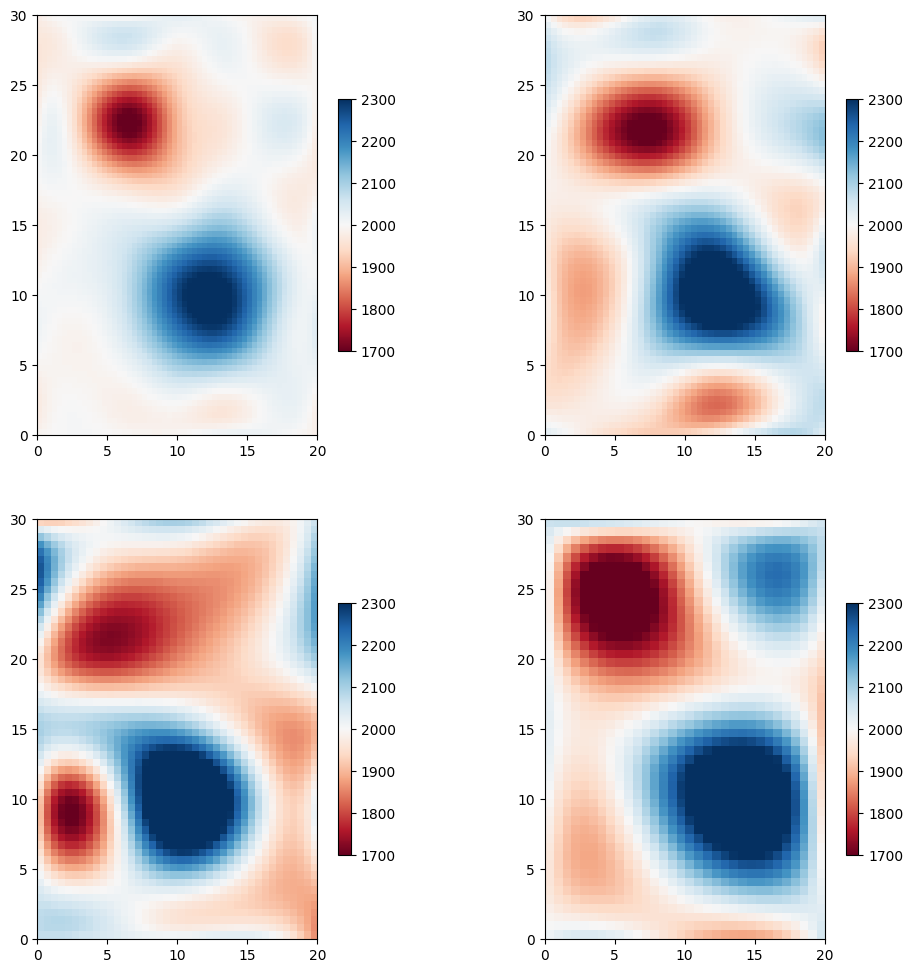

In [25]:
# plot map models
mapind,mapmodel = [],[]
fig, axes_2d = plt.subplots(2,2,figsize=(12,12))
axes = axes_2d.flatten()
mapll = []
for state in range(nstates):
    ind = np.argmax(log_probs_seq[state])
    mapm = ensembles_seq[state][ind]
    mapind.append(ind)
    mapmodel.append(mapm)
    nx,ny = stateparams['nx'][state], stateparams['ny'][state]
    pyfm2d.display_model(1./mapm.reshape((nx,ny)), extent=extent, ax = axes[state], clim=(1700, 2300), filename='smooth_maps_128.pdf')
    mapll.append(log_likelihood(mapm,state))
    print("LL for map ",mapll[state]," LL for starting model",posll[state])

### Build pseudo priors

In [26]:
pseudo_prior_type = 'direct'  # use direct fitting of a Gaussian to each ensemble to get pseudo prior
pseudo_prior_type = 'prior'   # pseudo prior set to prior
pseudo_prior_type = 'auto'    # use auto build routine to get pseudo prior

In [27]:
# Build pseudo-priors from the posterior ensembles
ensemble_per_state = ensembles_seq
log_posterior_ens = log_probs_seq

print("\nBuilding pseudo-priors from posterior ensembles...")

log_pseudo_prior_ens = []
start_time = time.time()
if(pseudo_prior_type == 'auto'): # By default this now standardizes the input enembles and rescales the Gaussian mixture class objects output to the routine built.
    log_pseudo_prior = build_auto_pseudo_prior(ensemble_per_state=ensemble_per_state,covariance_type='diag')
    print(f"\nBuild completed, evaluating ensemble")
    #for i, ens in enumerate(ensemble_per_state): # Evaluate pseudo-priors for all ensemble members
    #    log_pseudo_prior_ens.append(np.array([log_pseudo_prior(x, i) for x in ens]))
    for i, ens in enumerate(ensemble_per_state): # Evaluate pseudo-priors for all ensemble members
        log_pseudo_prior_ens.append(log_pseudo_prior(ens, i))

elif(pseudo_prior_type == 'prior'):

    log_pseudo_prior = log_prior
    print(f"\nBuild completed, evaluating ensemble")
    for i, ens in enumerate(ensemble_per_state): # Evaluate pseudo-priors for all ensemble members
        log_pseudo_prior_ens.append(log_pseudo_prior(ens, i))

elif(pseudo_prior_type == 'direct'):
    
    for state in range(nstates):
        cov = np.diag(np.var(ensemble_per_state[state],axis=0))
        mean = np.mean(ensemble_per_state[state],axis=0)
        rvl = stats.multivariate_normal(mean=mean,cov=cov)
        log_pseudo_prior_ens.append(rvl.logpdf(ensemble_per_state[state])) # direct estimation

pseudo_prior_time = time.time() - start_time

print(f"Pseudo-prior generation completed in {pseudo_prior_time:.2f} seconds")
print(f"Ready for ensemble resampler with:")
for i in range(nstates):
    print(f"  State {i}: {len(ensemble_per_state[i])} samples")

# Store ensemble resampler parameters  
er_n_walkers = 16  # Fewer walkers for faster demonstration
er_n_steps = 100000  # Sufficient steps for convergence

print(f"\nEnsemble resampler will use {er_n_walkers} walkers and {er_n_steps} steps")


Building pseudo-priors from posterior ensembles...

Build completed, evaluating ensemble
Pseudo-prior generation completed in 0.07 seconds
Ready for ensemble resampler with:
  State 0: 6400 samples
  State 1: 6400 samples
  State 2: 6400 samples
  State 3: 6400 samples

Ensemble resampler will use 16 walkers and 100000 steps


In [28]:
#log_probs_seq,log_pseudo_prior_ens

### Run ensemble sampler

In [29]:
print("=== BASELINE: Sequential Ensemble Resampler ===")
print("Running ensemble resampler with sequential walker execution...")

start_time = time.time()

# Sequential execution (no walker parallelism)
er_results_seq = run_ensemble_resampler(
    n_walkers=er_n_walkers,
    n_steps=er_n_steps,
    n_states=nstates,
    n_dims=ndims,
    log_posterior_ens=log_posterior_ens,
    log_pseudo_prior_ens=log_pseudo_prior_ens,
    progress=True
)

er_sequential_time = time.time() - start_time

# Extract some diagnostics
state_chains = er_results_seq.state_chain  # (n_walkers, n_steps)
n_accepted = er_results_seq.n_accepted
n_proposed = er_results_seq.n_proposed
acceptance_rates = n_accepted / n_proposed * 100

print(f"\nSequential ensemble resampler completed in {er_sequential_time:.2f} seconds")
print(f"State chain shape: {state_chains.shape}")
print(f"Average acceptance rate: {np.mean(acceptance_rates):.2f}%")
print(f"Acceptance rate range: {np.min(acceptance_rates):.2f}% - {np.max(acceptance_rates):.2f}%")

# Calculate state visitation frequencies
state_visits = np.bincount(state_chains.flatten(), minlength=nstates)
state_frequencies = state_visits / state_visits.sum()

print(f"State visitation frequencies:")
for i in range(nstates):
    print(f"  State {i}: {state_frequencies[i]:.3f} ({state_visits[i]:,} visits)")

# Store baseline for comparison
er_baseline_time = er_sequential_time
er_baseline_results = er_results_seq

2025-10-15 18:55:09 [INFO] pytransc.samplers.ensemble_resampler: 
Running ensemble resampler
2025-10-15 18:55:09 [INFO] pytransc.samplers.ensemble_resampler: 
Number of walkers               : 16
2025-10-15 18:55:09 [INFO] pytransc.samplers.ensemble_resampler: Number of states being sampled  : 4
2025-10-15 18:55:09 [INFO] pytransc.samplers.ensemble_resampler: Dimensions of each state        : [63, 48, 35, 24]


=== BASELINE: Sequential Ensemble Resampler ===
Running ensemble resampler with sequential walker execution...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.71it/s]


Sequential ensemble resampler completed in 5.91 seconds
State chain shape: (16, 99999)
Average acceptance rate: 0.01%
Acceptance rate range: 0.00% - 0.01%
State visitation frequencies:
  State 0: 0.000 (4 visits)
  State 1: 0.966 (1,544,983 visits)
  State 2: 0.002 (3,562 visits)
  State 3: 0.032 (51,435 visits)


In [30]:
# Walker parallelism - but given we resample i don't expect a speed up

start_time = time.time()

n_walker_procs=4
# Walker parallelism)

with ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:

    er_results_seq = run_ensemble_resampler(
        n_walkers=er_n_walkers,
        n_steps=er_n_steps,
        n_states=nstates,
        n_dims=ndims,
        log_posterior_ens=log_posterior_ens,
        log_pseudo_prior_ens=log_pseudo_prior_ens,
        walker_pool=walker_pool,
        progress=True
    )

er_parallel_time = time.time() - start_time

print(f"\nSequential {er_baseline_time:.2f} seconds")
print(f"Parallel {er_parallel_time:.2f} seconds")

2025-10-15 18:55:14 [INFO] pytransc.samplers.ensemble_resampler: 
Running ensemble resampler
2025-10-15 18:55:14 [INFO] pytransc.samplers.ensemble_resampler: 
Number of walkers               : 16
2025-10-15 18:55:14 [INFO] pytransc.samplers.ensemble_resampler: Number of states being sampled  : 4
2025-10-15 18:55:14 [INFO] pytransc.samplers.ensemble_resampler: Dimensions of each state        : [63, 48, 35, 24]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.06it/s]


Sequential 5.91 seconds
Parallel 2.10 seconds


In [31]:
%watermark -v -d -t -z -iv

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.6.0

tqdm      : 4.67.1
sklearn   : 1.7.2
pytransc  : 0.2.0
matplotlib: 3.10.7
scipy     : 1.16.2
pyfm2d    : 0.1.5
numpy     : 2.3.3

